In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/My\ Drive/New\ Dataset /content/Dataset

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model

import random as rn
import numpy as np

Set up tensorflow session.

In [4]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

Build classification model using VGG16.

In [5]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
def build_model():

  # Freeze vgg model
  for layer in vgg_model.layers:
      layer.trainable = False
  vgg_model.trainable = False
  classification_model = keras.layers.Flatten(name="flatten")(vgg_model.output)
  classification_model = keras.layers.Dense(512, activation="relu")(classification_model)
  classification_model = keras.layers.Dropout(0.25)(classification_model)
  classification_model = keras.layers.Dense(3, activation="softmax")(classification_model)

  model = Model(inputs=vgg_model.input, outputs=classification_model)

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-4),
      loss=keras.losses.categorical_crossentropy,
      metrics=['accuracy'])
  
  return model

model = build_model()
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_______________________________________________________

In [6]:
SEED = 42
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255,
  rotation_range=45,           # apply rotations to augment data
  width_shift_range=0.2,       # horizontal shift
  height_shift_range=0.2,      # vertical shift
  horizontal_flip=True,        # image flips
  zoom_range=0.2,              # zoom
  brightness_range=[0.8,1.2],   # brightness
  fill_mode='nearest'
)
batchsize = 10
train_generator = train_datagen.flow_from_directory(
  directory = "/content/Dataset/train",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = True,
  class_mode = 'categorical',
  seed=SEED
)

batchsize = 1
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=(1/255))
valid_generator = valid_datagen.flow_from_directory(
  directory = "/content/Dataset/validation",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = True,
  class_mode = 'categorical'
)

Found 380 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [7]:
loss0, accuracy0 = model.evaluate(valid_generator)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

63/63 [==============================] - 24s 388ms/step - loss: 1.3432 - accuracy: 0.3333
initial loss: 1.34
initial accuracy: 0.33


In [8]:
def get_class_weight():
  bathroom = 133
  bedroom = 134
  kitchen = 113
  total = bathroom + bedroom + kitchen
  class_weight = {0: total / bathroom, 1: total / bedroom, 2: total / kitchen}
  return class_weight

In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg_{epoch:03d}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_freq='epoch')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

training = model.fit(
  train_generator,
  class_weight=get_class_weight(),
  epochs=100,
  validation_data=valid_generator,
  callbacks=[checkpoint, early_stopping],
  verbose=1,
)

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.9259 - accuracy: 0.5737
Epoch 00001: val_accuracy improved from -inf to 0.76190, saving model to vgg_001.h5
38/38 [==============================] - 171s 5s/step - loss: 2.9259 - accuracy: 0.5737 - val_loss: 0.6429 - val_accuracy: 0.7619
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.7357 - accuracy: 0.7632
Epoch 00002: val_accuracy improved from 0.76190 to 0.82540, saving model to vgg_002.h5
38/38 [==============================] - 13s 349ms/step - loss: 1.7357 - accuracy: 0.7632 - val_loss: 0.5271 - val_accuracy: 0.8254
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 1.4841 - accuracy: 0.8132
Epoch 00003: val_accuracy improved from 0.82540 to 0.85714, saving model to vgg_003.h5
38/38 [==============================] - 13s 349ms/step - loss: 1.4841 - accuracy: 0.8132 - val_loss: 0.4292 - val_accuracy: 0.8571
Epoch 4/100
38/38 [==============================] - ETA: 0s - 

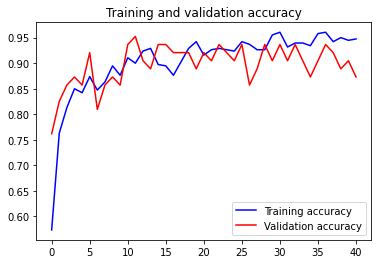

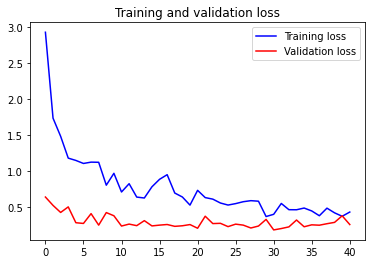

In [10]:
accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Unfreeze top layers of VGG model and procede with training.

In [12]:
vgg_model.trainable = True
num = len(vgg_model.layers) - 8
for layer in vgg_model.layers[num:]:
  layer.trainable =  True


model.compile(
  optimizer=keras.optimizers.RMSprop(lr=1e-5),
  loss=keras.losses.categorical_crossentropy,
  metrics=['accuracy'])

training_fine = model.fit(train_generator,
  class_weight=get_class_weight(),
  epochs=100,
  validation_data=valid_generator,
  initial_epoch=training.epoch[-1],
  callbacks=[checkpoint, early_stopping],
  verbose=1,
)

Epoch 41/100
38/38 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.9158
Epoch 00041: val_accuracy did not improve from 0.95238
38/38 [==============================] - 14s 380ms/step - loss: 0.7349 - accuracy: 0.9158 - val_loss: 0.4151 - val_accuracy: 0.8889
Epoch 42/100
38/38 [==============================] - ETA: 0s - loss: 0.4815 - accuracy: 0.9368
Epoch 00042: val_accuracy did not improve from 0.95238
38/38 [==============================] - 15s 382ms/step - loss: 0.4815 - accuracy: 0.9368 - val_loss: 0.4023 - val_accuracy: 0.9048
Epoch 43/100
38/38 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.9421
Epoch 00043: val_accuracy did not improve from 0.95238
38/38 [==============================] - 14s 381ms/step - loss: 0.5744 - accuracy: 0.9421 - val_loss: 0.3086 - val_accuracy: 0.9365
Epoch 44/100
38/38 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.9737
Epoch 00044: val_accuracy did not improve from 0.95238


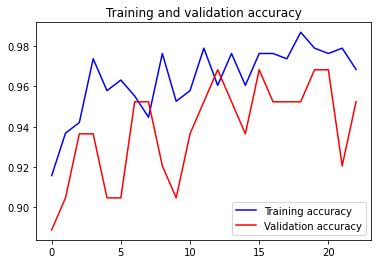

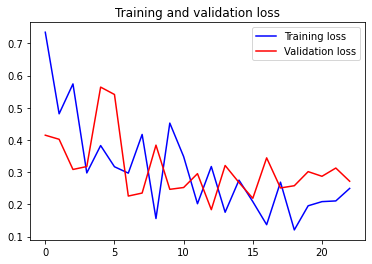

In [14]:
accuracy = training_fine.history['accuracy']
val_accuracy = training_fine.history['val_accuracy']
loss = training_fine.history['loss']
val_loss = training_fine.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
tsdata = ImageDataGenerator(rescale=(1./255))
test_generator = tsdata.flow_from_directory(
  directory="/content/Dataset/test",
  target_size=(256, 256),
  shuffle=True,
  batch_size=1,
  seed=42
)

model = load_model('vgg_053.h5')

results = model.evaluate(test_generator)
print(results)
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)
print(classification_report(test_generator.classes, predictions,
	target_names=test_generator.class_indices.keys()))
print(confusion_matrix(test_generator.classes, predictions))

Found 82 images belonging to 3 classes.
82/82 [==============================] - 32s 385ms/step - loss: 0.1031 - accuracy: 0.9634
[0.10305780172348022, 0.9634146094322205]
              precision    recall  f1-score   support

    Bathroom       0.48      0.44      0.46        25
     Bedroom       0.53      0.51      0.52        37
     Kitchen       0.35      0.40      0.37        20

    accuracy                           0.46        82
   macro avg       0.45      0.45      0.45        82
weighted avg       0.47      0.46      0.47        82

[[11  9  5]
 [ 8 19 10]
 [ 4  8  8]]


Grad-CAM

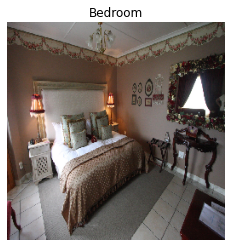

In [16]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "flatten",
    "dense",
    "dropout",
    "dense_1"
]

def get_label_number(label):
  if label[0] == 1:
    return 0
  elif label[1] == 1: 
    return 1
  else:
    return 2

class_dict = test_generator.class_indices
image, label = test_generator.next()
for j in range(0, 1):
  plt.imshow(image[j])
  plt.title(list(class_dict.keys())[list(class_dict.values()).index(get_label_number(label[j]))])
  plt.axis("off")

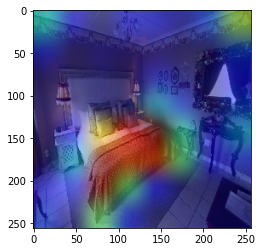

In [17]:
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
classification_net = classifier_input
for layer_name in classifier_layer_names:
  classification_net = model.get_layer(layer_name)(classification_net)
  classifier_model = keras.Model(classifier_input, classification_net)

with tf.GradientTape() as tape:
  # Compute activations of the last conv layer and make the tape watch it
  last_conv_layer_output = last_conv_layer_model(image)
  tape.watch(last_conv_layer_output)
  # Compute class predictions
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  top_class_channel = preds[:, top_pred_index]

# Gradient of the top predicted class
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis=-1)

# Normalize heatmap between 0 and 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

colormap = cm.get_cmap("jet")(heatmap)[:,:,:3]

# Create image with color heatmap
colormap = keras.preprocessing.image.array_to_img(colormap)
colormap = colormap.resize((image[j].shape[1], image[j].shape[0]))
colormap = keras.preprocessing.image.img_to_array(colormap)

# Overlay the heatmap on original image
overlaid_img = image[j]*0.5 + colormap*0.5/255
overlaid_img = keras.preprocessing.image.array_to_img(overlaid_img)

plt.imshow(overlaid_img)
